In [42]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit-aer
!pip install 'qiskit[visualization]'

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import qiskit_ibm_runtime
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
# Get a fake backend from the fake provider
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

In [44]:
# method 1: Using diagonalization

H = np.matrix([
    [-17.1715, -0.3949, -0.3536, -0.2312, -0.5932],
    [-0.3949, -12.5785, -0.6209, -0.3796, -0.3992],
    [-0.3536, -0.6209, -14.6856, -0.2977, -0.3659],
    [-0.2312, -0.3796, -0.2977, -16.4997, -0.2440],
    [-0.5932, -0.3992, -0.3659, -0.2440, -18.7504]])

e,v = np.linalg.eig(H)

print('EigenValues : ', e)
print('EigenVectors: ', v)
print()

print(f"Ground state energy (minimum eigenvalue): {min(e):.6f}")


EigenValues :  [-12.36285085 -19.10320303 -14.68877845 -17.07038628 -16.46048139]
EigenVectors:  [[ 0.05405394 -0.34129343 -0.13429063 -0.85620622  0.35982482]
 [-0.96726311 -0.09709155  0.2089675  -0.08304916 -0.0664133 ]
 [ 0.23560921 -0.12649883  0.95011213 -0.12569291 -0.09987283]
 [ 0.06645696 -0.14467921 -0.17258827 -0.29967197 -0.9246953 ]
 [ 0.03939566 -0.91496339 -0.07615016  0.3929526   0.03285411]]

Ground state energy (minimum eigenvalue): -19.103203


In [45]:
# method2: using classical variational method

# Define the 5x5 Hamiltonian
H = np.array([
    [-17.1715, -0.3949, -0.3536, -0.2312, -0.5932],
    [-0.3949, -12.5785, -0.6209, -0.3796, -0.3992],
    [-0.3536, -0.6209, -14.6856, -0.2977, -0.3659],
    [-0.2312, -0.3796, -0.2977, -16.4997, -0.2440],
    [-0.5932, -0.3992, -0.3659, -0.2440, -18.7504]
])

# Trial wavefunction using 4 angular parameters (generalized spherical coordinates)
def trial_wavefunction_5d(params):
    assert len(params) == 4, "Need 4 parameters for a 5D unit vector"

    theta1, theta2, theta3, theta4 = params
    psi = np.zeros(5)

    psi[0] = np.cos(theta1)
    psi[1] = np.sin(theta1) * np.cos(theta2)
    psi[2] = np.sin(theta1) * np.sin(theta2) * np.cos(theta3)
    psi[3] = np.sin(theta1) * np.sin(theta2) * np.sin(theta3) * np.cos(theta4)
    psi[4] = np.sin(theta1) * np.sin(theta2) * np.sin(theta3) * np.sin(theta4)

    return psi

# Variational energy function
def classical_variational_5d(H):
    def energy(params):
        psi = trial_wavefunction_5d(params)
        ec = psi.T @ H @ psi
        return ec  # already a scalar

    # Initial guess: mid-range angles
    initial_params = [np.pi / 4] * 4

    # Bounds for each angle: [0, π] or [0, 2π] — here we use [0, π]
    bounds = [(0, np.pi)] * 4

    result = minimize(energy, initial_params, bounds=bounds)

    min_energy = result.fun
    return min_energy

# Run variational minimization
min_energy = classical_variational_5d(H)
print(f"Ground state energy (minimum eigenvalue estimate): {min_energy:.6f}")


Ground state energy (minimum eigenvalue estimate): -17.171500


In [49]:
# method3: using VQE

# Estimator using Fake Provider
backend = FakeManilaV2()
estimator = Estimator(mode=backend)
#Giving number of shots
estimator.options.default_shots = 10000

In [50]:
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([
    ("IIIII", -39.8419),
    ("IIIIZ", 8.5858),
    ("IIIZI", 6.28925),
    ("IIZII", 7.3428),
    ("IZIII", 8.24885),
    ("ZIIII", 9.3752),
    ("IIIXX", -0.19745),
    ("IIIYY", -0.19745),
    ("IIXZX", -0.1768),
    ("IIYZY", -0.1768),
    ("IXZZX", -0.1156),
    ("IYZZY", -0.1156),
    ("XZZZX", -0.2966),
    ("YZZZY", -0.2966),
    ("IIXXI", -0.31045),
    ("IIYYI", -0.31045),
    ("IXIXI", -0.1898),
    ("IYIYI", -0.1898),
    ("XIIXI", -0.1996),
    ("YIIYI", -0.1996),
    ("IXXII", -0.14885),
    ("IYYII", -0.14885),
    ("XIXII", -0.18295),
    ("YIYII", -0.18295),
    ("XXIII", -0.122),
    ("YYIII", -0.122)
])


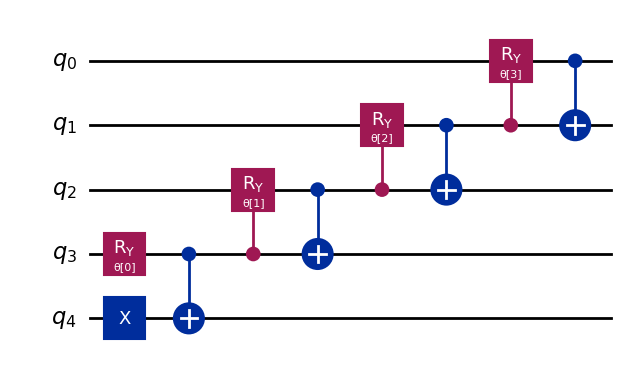

In [51]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# Create a parameter vector with 4 parameters
theta = ParameterVector('θ', 4)

# Initialize a 5-qubit quantum circuit
ansatz = QuantumCircuit(5)

ansatz.ry(theta[0],3)
ansatz.x(4)
ansatz.cx(3,4)

ansatz.cry(theta[1], 3, 2)
ansatz.cx(2,3)

ansatz.cry(theta[2], 2, 1)
ansatz.cx(1,2)

ansatz.cry(theta[3], 1, 0)
ansatz.cx(0,1)

ansatz.draw("mpl")



In [52]:
# Transpile the Hamiltonian and ansatz
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [53]:
backend = FakeManilaV2()
estimator = Estimator(mode=backend)
#Giving number of shots
estimator.options.default_shots = 10000

In [54]:
#Function to calcuate energy
def variational(params, ansatz, hamiltonian, estimator):

  """Parameters:
       params (ndarray): Array of ansatz parameters
       ansatz (QuantumCircuit): Parameterized ansatz circuit
       hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
       estimator (EstimatorV2): Estimator primitive instance"""
  pub = (ansatz, hamiltonian, [params])
  result = estimator.run(pubs=[pub]).result()
  energy = result[0].data.evs[0]
  return energy


In [55]:
# Minimization function for each Hamiltonian
def minimization(ansatz_isa, hamiltonian_isa, ansatz):
    x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
    result = minimize(
        variational,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="COBYLA"
    )
    return result.fun


In [56]:
# ground state energy from VQE

result = minimization(ansatz_isa, hamiltonian_isa, ansatz)
print(f"Ground state energy of JW: {result}")


Ground state energy of JW: -19.77496466999999


In [57]:
runs = np.arange(1,11,1)
E_runs = []
for i in runs:
    E_runs.append(minimization(ansatz_isa, hamiltonian_isa, ansatz))
print(f"JW: {E_runs}")

JW: [np.float64(-19.88488786), np.float64(-19.861115329999993), np.float64(-19.820435780000004), np.float64(-19.905968920000007), np.float64(-19.947047470000008), np.float64(-19.859630689999992), np.float64(-19.821257449999997), np.float64(-20.09535628), np.float64(-19.798695969999994), np.float64(-19.838143159999998)]


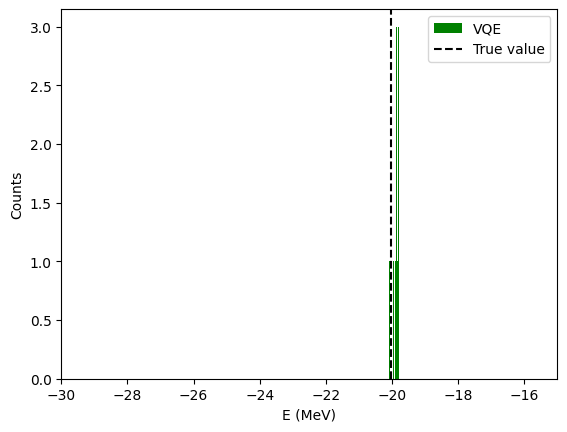

In [59]:
# True value for first exited state of 58Ni
true_value = -20.024# (MeV)

plt.hist(np.array(E_runs),label = 'VQE',color = 'green')
plt.xlabel('E (MeV)')
plt.ylabel('Counts')
plt.axvline(x = true_value, ymin = 0, ymax = 1, linestyle = '--', c = 'k', label = 'True value')
plt.xlim(-30,-15)
plt.legend()
plt.show()